In [1]:
from numpy import zeros

from sklearn import preprocessing, pipeline, svm
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
import cogent
from cogent import LoadSeqs, DNA, LoadTree
from cogent.draw.dendrogram import UnrootedDendrogram
from rpy2.robjects.packages import importr
import seaborn as sns
from pandas import DataFrame

In [2]:
%matplotlib inline

In [3]:
%load_ext rpy2.ipython
peptides = importr('Peptides')

In [4]:
apd_data = [l.strip('\xc2\xa0') for l in open('../data/APD3-AH-AMP.txt').read().split()]
pdb_data = set(LoadSeqs('../data/pdb_coiled_coil.fasta', format='fasta', aligned=False).todict().values())
apd_data = [d for d in apd_data if len(d) >= 8 and len(d) <= 40]
pdb_data = [d for d in pdb_data if len(d) >= 8 and len(d) <= 40]
print len(apd_data), 'AMPs'
print len(pdb_data), 'CCs'

361 AMPs
371 CCs


In [5]:
factors = [peptides.charge,
           peptides.hydrophobicity,
           peptides.hmoment,
           peptides.instaIndex]
X = [[f(s)[0] for f in factors]
     for s in apd_data + pdb_data]
y = [1]*len(apd_data) + [0]*len(pdb_data)

In [6]:
svc = pipeline.Pipeline(
    steps=[('scale', preprocessing.StandardScaler()),
           ('svm', svm.LinearSVC())])
p_grid = {'svm__C': [0.01, 0.1, 1., 10., 100.],
          'svm__loss': ['hinge', 'squared_hinge']}
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
classifier = GridSearchCV(estimator=svc, param_grid=p_grid, cv=cv)
classifier.fit(X, y)
print classifier.best_params_
print classifier.best_score_

{'svm__loss': 'squared_hinge', 'svm__C': 1.0}
0.863387978142


In [7]:
def get_factors(seq, factors=factors):
    return [f(seq)[0] for f in factors]

def is_antimicrobial(seq, classifier=classifier, length=22, factors=factors):
    seq = seq.replace('-', '')
    if len(seq) < length:
        return False
    x = get_factors(seq, factors)
    return bool(classifier.predict([x])[0])

def amp_prob(seq, factors=factors):
    seq = seq.replace('-', '')
    x = get_factors(seq, factors)
    return classifier.decision_function([x])[0]

In [8]:
joint = LoadSeqs('../results/joint.fasta', moltype=DNA)
joint = joint.getTranslation()
joint = joint.todict().values()

In [9]:
minlen = 8
maxminlen = 40
jointlen = len(joint[0])
antimicrobial_count = zeros((jointlen-minlen, jointlen),
                            dtype=int)
for start in range(jointlen):
    for maxlen in range(minlen, jointlen-start):
        thisminlen = jointlen
        for seq in joint:
            len_ = maxlen - seq[start:start+maxlen].count('-')
            thisminlen = min(thisminlen, len_)
        if thisminlen > maxminlen:
            break
        for seq in joint:
            antimicrobial_count[maxlen - minlen, start] += \
                is_antimicrobial(seq[start:start+maxlen], length=minlen)

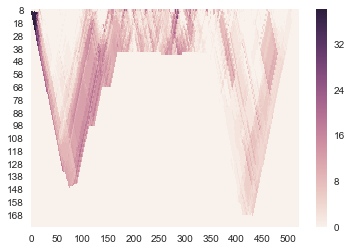

In [10]:
centrered_count = []
yrange = 178
for i, row in enumerate(antimicrobial_count[:yrange-minlen]):
    pad = int(i/2)
    centrered_count.append([0]*pad + list(row[:jointlen-pad]))
df = DataFrame(centrered_count,
               index=range(minlen, yrange))
ax = sns.heatmap(df, yticklabels=10, xticklabels=50, );

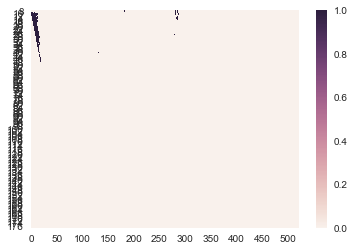

In [11]:
sns.heatmap(df > 21, yticklabels=2, xticklabels=50);

In [12]:
peptides = []
for start in range(jointlen):
    for maxlen in range(jointlen - start):
        if antimicrobial_count[maxlen - minlen, start] > 21:
            peptides.append((start, start+maxlen, 
                             antimicrobial_count[maxlen - minlen, start]))
keepers = []
for start1, end1, count1 in peptides:
    dominated = False
    for start2, end2, count2 in peptides:
        if ((start2 <= start1 and end2 >= end1 and count2 >= count1) and
            (start2 != start1 or end2 != end1)):
            dominated = True
    if not dominated and start1 != 0:
        print start1, end1, end1 - start1, count1
        keepers.append((start1, end1))

116 156 40 22
182 191 9 23
270 297 27 22
282 297 15 27
283 291 8 30


Found 22 AMPs between 116 and 156
Found 23 AMPs between 182 and 191
Found 22 AMPs between 270 and 297
Found 27 AMPs between 282 and 297
Found 30 AMPs between 283 and 291


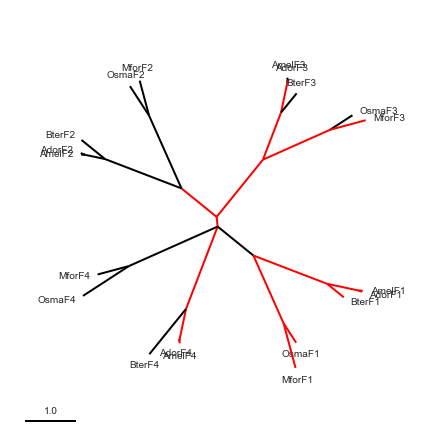

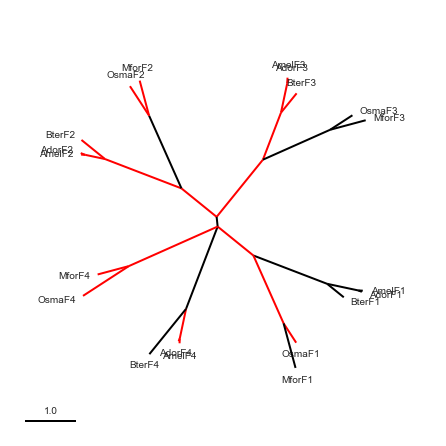

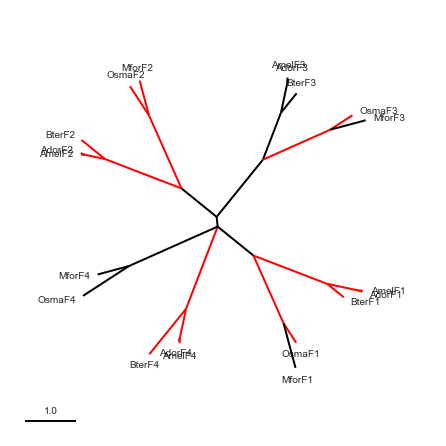

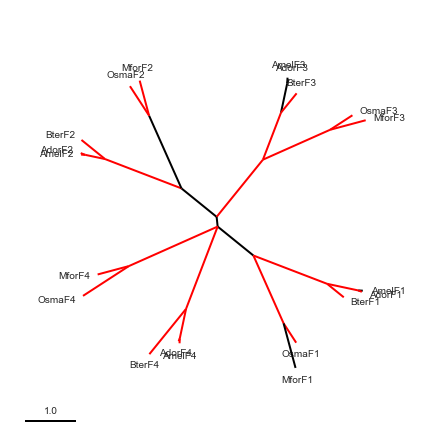

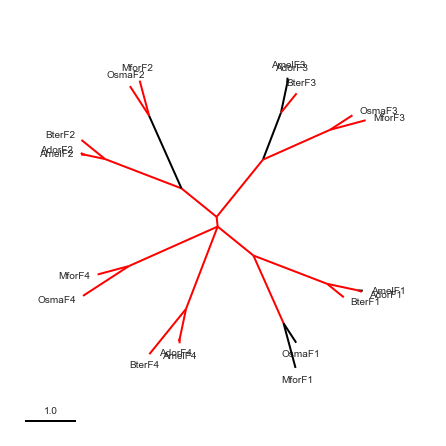

In [13]:
column_labels = ['taxon', 'sequence', 'locus', 'ampness', 'is_amp',
              'charge', 'hydophobicity', 'hmoment', 'insta_index']
rows = []
for start, end in keepers:
    tree = LoadTree('../results/cnfgtr.nwk')
    joint = LoadSeqs('../results/joint.fasta', moltype=DNA)
    joint = joint.getTranslation()
    joint_peptide = joint[start:end]
    amps = []
    for label, node in tree.getNodesDict().items():
        seq = str(joint_peptide.getGappedSeq(label))
        node.params['AMP'] = is_antimicrobial(seq, length=8)
        if node.params['AMP']:
            amps.append(label)
        row = [label, seq.replace('-', ''), str(start)+'-'+str(end),
               amp_prob(seq), node.params['AMP']]
        row += get_factors(seq)
        rows.append(row)
    dend = UnrootedDendrogram(tree)
    fig = dend.makeFigure(height=6, width=6, shade_param='AMP',
                          max_value=1.0, stroke_width=2)
    print 'Found', len(amps), 'AMPs between', start, 'and', end
    filename = 'amps-'+str(start)+'-'+str(end)
    fig.savefig('../results/'+filename+'.pdf')
    amps = joint_peptide.takeSeqs(amps).todict()
    amps = LoadSeqs(data=amps)
    amps.degap().writeToFile('../results/'+filename+'.fasta')

In [14]:
joint = LoadSeqs('../results/joint.fasta', moltype=DNA)
joint = joint.getTranslation()
amelF3 = joint.getGappedSeq('AmelF3')
# Looking for KIKTSASVNAKAAAVVKASALALAEAYLRASALSAAASAKAAAALKNA
start = 135
end = 194
print str(amelF3)[start:end]

KIKT-----------SASVNAKAAAVVKASALALAEAYLRASALSAAASAKAAAALKNA


Found 10 AMPs


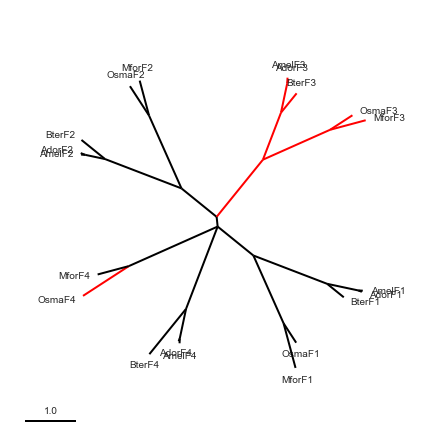

In [15]:
amps = []
joint_peptide = joint[start:end]
for label, node in tree.getNodesDict().items():
    seq = str(joint_peptide.getGappedSeq(label))
    node.params['AMP'] = is_antimicrobial(seq, length=3)
    if node.params['AMP']:
        amps.append(label)
    row = [label, seq.replace('-', ''), 'KIKT region',
           amp_prob(seq), node.params['AMP']]
    row += get_factors(seq)
    rows.append(row)
dend = UnrootedDendrogram(tree)
fig = dend.makeFigure(height=6, width=6, shade_param='AMP',
                      max_value=1.0, stroke_width=2)
fig.savefig('../results/tara_tree.pdf')
print 'Found', len(amps), 'AMPs'
amps = joint_peptide.takeSeqs(amps).todict()
amps = LoadSeqs(data=amps)
amps.degap().writeToFile('../results/tara_amps.fasta')

In [16]:
joint = LoadSeqs('../results/joint.fasta', moltype=DNA)
joint = joint.getTranslation()
amelF3 = joint.getGappedSeq('AmelF3')
# Looking for RASALSAAASAKAAAALKNAQQAQLNAQEKSLAALKAQS
start = 174
end = 213
print str(amelF3)[start:end]

RASALSAAASAKAAAALKNAQQAQLNAQEKSLAALKAQS


Found 9 AMPs


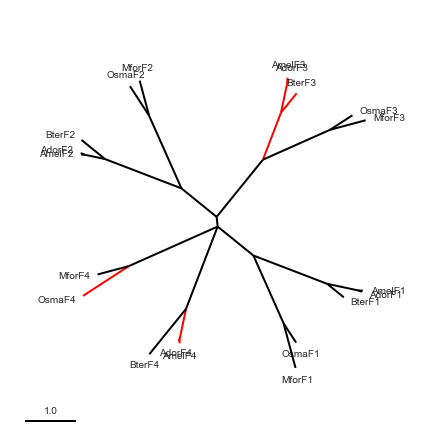

In [17]:
amps = []
joint_peptide = joint[start:end]
for label, node in tree.getNodesDict().items():
    seq = str(joint_peptide.getGappedSeq(label))
    node.params['AMP'] = is_antimicrobial(seq, length=3)
    if node.params['AMP']:
        amps.append(label)
    row = [label, seq.replace('-', ''), 'flocculator',
           amp_prob(seq), node.params['AMP']]
    row += get_factors(seq)
    rows.append(row)
dend = UnrootedDendrogram(tree)
fig = dend.makeFigure(height=6, width=6, shade_param='AMP',
                      max_value=1.0, stroke_width=2)
fig.savefig('../results/flocculator_tree.pdf')
print 'Found', len(amps), 'AMPs'
amps = joint_peptide.takeSeqs(amps).todict()
amps = LoadSeqs(data=amps)
amps.degap().writeToFile('../results/flocculator_amps.fasta')

In [18]:
results = DataFrame(rows, columns=column_labels)
results.sort_values('ampness', ascending=False, inplace=True)
results.to_csv('../results/amps.csv', index=False)